In [2]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import itertools
import math
import itertools
from tqdm import tqdm

In [3]:
filename = 'data/images/eye.jpg'
img = np.asarray(Image.open(filename))

# 1. Basic operation on pixels

In [4]:
class PixelProcessor:
    def __init__(self, filepath:str):
        self.img = np.asarray(Image.open(filepath))

    def get_grey_image(self):
        return np.apply_along_axis(self._pixel2gray, -1, self.img)

    def get_grey_image2(self):
        return np.apply_along_axis(self._pixel2gray2, -1, self.img)

    def get_negate(self):
        return 255 - self.img 
    
    def get_normalized(self, a:int, img=None):
        if img is None:
            img=self.img
        return np.apply_along_axis(self._normalize_pixel, -1, img, a)
    
    def get_normalized_logarithm(self):
        return np.apply_along_axis(self._normalize__logarithm_pixel, -1, self.img)
    
    def get_brightness(self, brightness):
        brightened =  self.img + brightness
        brightened[brightened < 0] = 0
        brightened[brightened > 255] = 255
        return brightened
    
    def normalization(self, new_max):
        pass
    
    def get_contrast(self, contrast: float):
        # http://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
        F = (259 * (contrast + 255)) / (255 * (259 - contrast))
        return np.apply_along_axis(self._contrast_pixel, -1, self.img, F)

    def get_global_thresholding_simple(self, threshold):
        # http://www.cse.iitd.ernet.in/~pkalra/col783/Thresholding.pdf
        img = self.get_grey_image()
        return np.apply_along_axis(self._threshold, -1, img, threshold)

    def get_histogram(self):
        # TODO Histogram equalization
        unique, counts = np.unique(self.img, return_counts=True)
        plt.figure(figsize=(20, 10))
        plt.bar(unique, counts)

    def get_image_projection_row_wise(self, threshold):
        # Transform to binary image
        img = self.get_global_thresholding_simple(threshold)
        height, width, _ = img.shape
        row_projection = [sum(r for r, g, b in row)//3 for row in img]
        ran = list(range(height))
        plt.figure(figsize=(20, 10))
        plt.gca().invert_yaxis()
        plt.barh(ran, row_projection)

    def get_image_projection_column_wise(self, threshold):
        img = self.get_global_thresholding_simple(threshold)
        column_grey_img = np.transpose(img, (1, 0, 2))
        width, height, _ = column_grey_img.shape
        column_projection = [sum(r for r, g, b in column)//3 for column in column_grey_img]
        ran = list(range(width))
        plt.figure(figsize=(20, 10))
        plt.bar(ran, column_projection)

    def convolution(self, filter: list, grayscale:bool = False, img=None):
        if img is None:
            img = self.img
        if grayscale:
            img = self.get_grey_image()
        filter_sum = sum(sum(i) for i in zip(*filter))
        assert filter_sum != 0, "Sum should be non zero!"
        filter = np.array(filter)
        height, width = filter.shape
        filter = filter.flatten()

        new_image = []
        print(f'Applying filter {filter}')
        for index, rows in enumerate(zip(*[img[i:] for i in range(height)])):
            new_image.append([])
            for frame in zip(*itertools.chain(*[[row[i:] for i in range(width)] for row in rows])):
                frame = np.array(frame)
                r, g, b = [frame[:, i] for i in range(3)]
                new_pixel = np.dot([r, g, b], filter).astype(np.uint8)
                # TODO which normalization
                #new_pixel = np.divide(new_pixel, filter_sum).astype(np.uint8)
                #new_pixel = self._normalize_pixel(new_pixel, 40)
                new_image[index].append(new_pixel)
        return np.array(new_image)
    
    @staticmethod
    def _normalize_pixel(pixel, a):
        new_pixel = [255*((color/255)**a) for color in pixel]
        return pixel
    @staticmethod
    def _normalize__logarithm_pixel(pixel):
        new_pixel = [255*(math.log(1+color)/math.log(1+255)) for color in pixel]
        return pixel

    @staticmethod
    def _pixel2gray(pixel):
        grey = float(sum(pixel) // 3)  # Average of 3 colors
        return [grey] * len(pixel)

    @staticmethod
    def _pixel2gray2(pixel):
        scale = [0.2126, 0.7152, 0.0722]  # factor to grayscale
        return [val * scal for val, scal in zip(pixel, scale)]

    @staticmethod
    def _contrast_pixel(pixel, factor):
        return [factor * (color - 128) + 128 for color in pixel]

    @staticmethod
    def _threshold(pixel, threshold):
        return [1. if color > threshold else 0. for color in pixel]
pixel_processor = PixelProcessor(filename)

In [6]:
class Filters:
    @staticmethod
    def low_pass(a :int):
        return [[1,1,1],[1,a,1],[1,1,1]]
    @staticmethod
    def gaussian(b:int):
        return [[1,b,1],[b,b**2,b],[1,b,1]]
    class HighPass:
        @staticmethod
        def laplacian():
            return [[0,-1,0],[-1,4,-1],[0,-1,0]]
        @staticmethod
        def derivatives_on_the_diagonals():
            return [[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]
        @staticmethod
        def derivatives_for_three_parallel_lines_in_vertical_and_horizontal():
            return [[-2,1,-2],[1,4,1],[-2,1,-2]]
    @staticmethod
    def identity():
        return [[0,0,0],[0,1,0],[0,0,0]]
    @staticmethod
    def sharpen():
        return [[0,-1,0],[-1,5,-1],[0,-1,0]]
    class EdgeDetecting:
        @staticmethod
        def roberts():
            return [[0,-1],[-1,0]]
        @staticmethod
        def prewitt():
            return [[1,1,1],[0,0,0],[-1,-1,-1]]
        @staticmethod
        def sobel():
            return [[-1,0,1],[-2,0,2],[-1,0,1]]

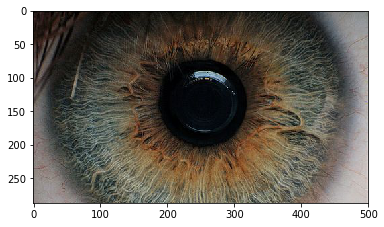

In [5]:
imshow(pixel_processor.img)

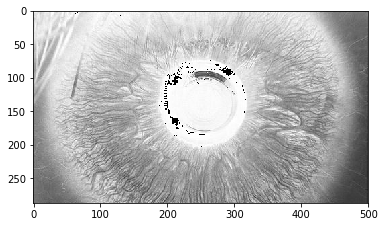

In [6]:
gray = pixel_processor.get_grey_image()
imshow(gray)

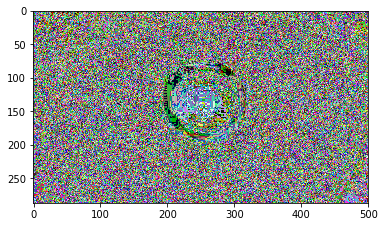

In [247]:
gray2 = pixel_processor.get_grey_image2()
imshow(gray2)

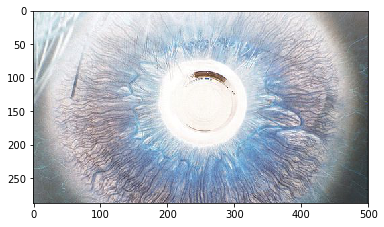

In [10]:
imshow(pixel_processor.get_negate())

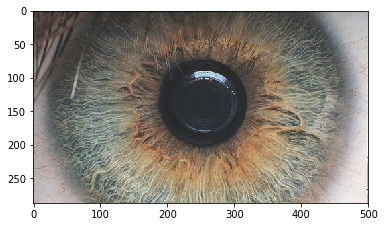

In [11]:
imshow(pixel_processor.get_brightness(40))

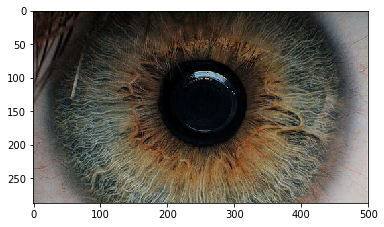

In [12]:
imshow(pixel_processor.get_contrast(1.006))

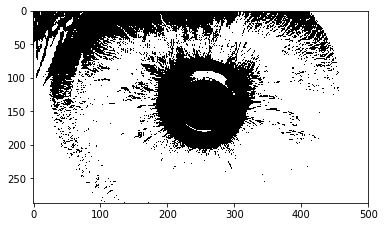

In [13]:
imshow(pixel_processor.get_global_thresholding_simple(40))

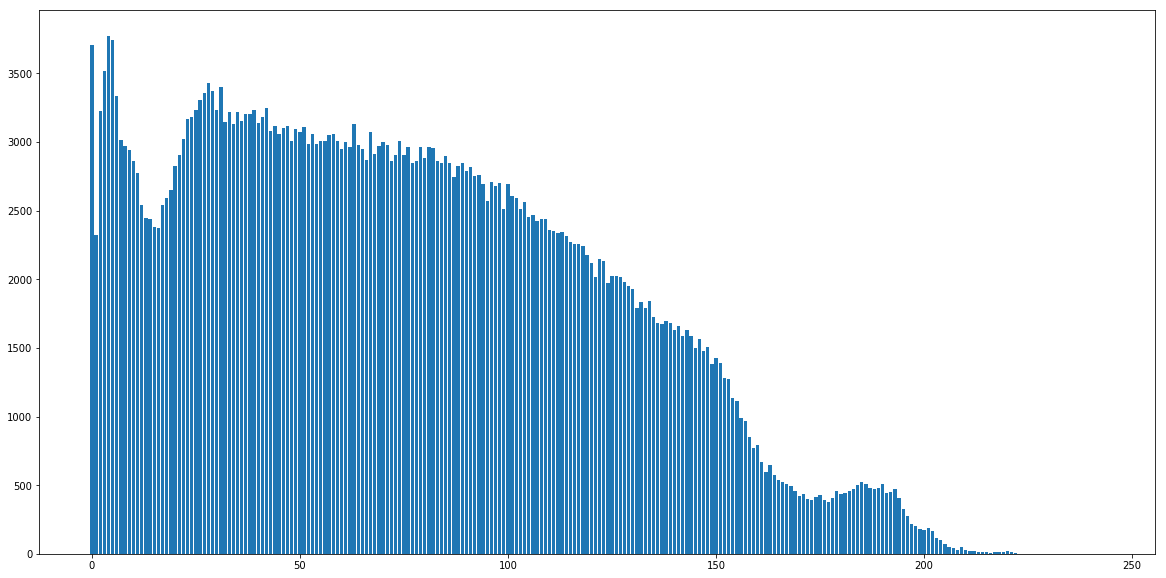

In [14]:
pixel_processor.get_histogram()

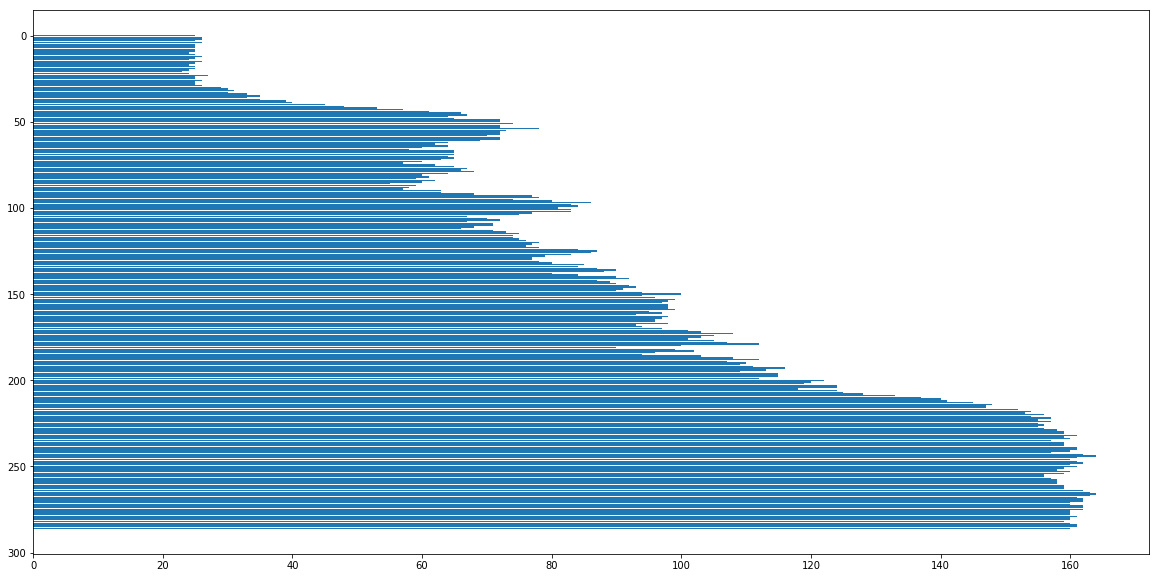

In [15]:
pixel_processor.get_image_projection_row_wise(60)

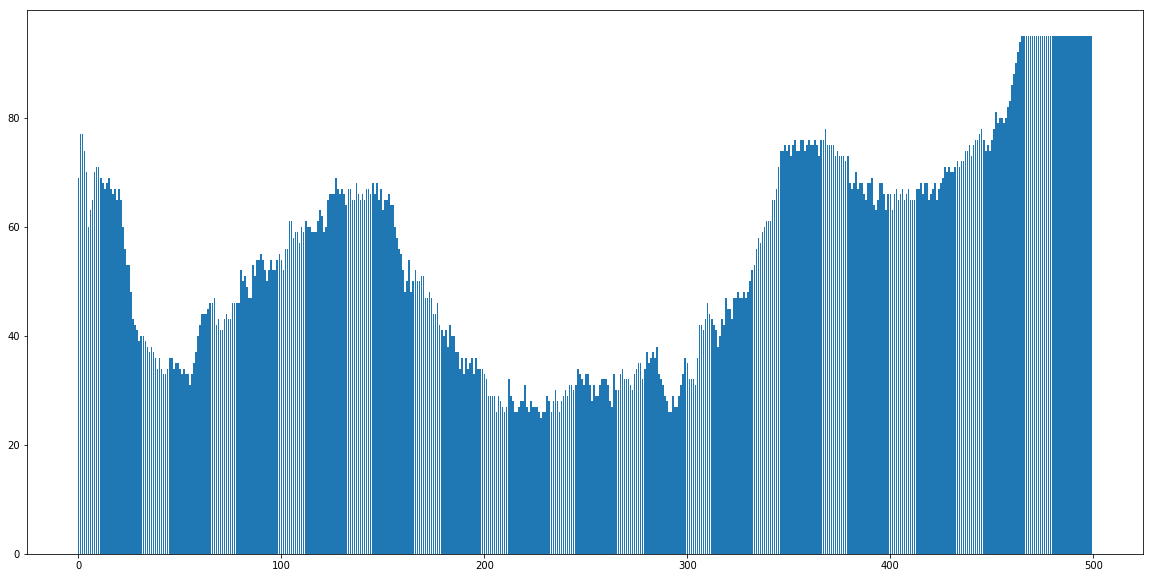

In [16]:
pixel_processor.get_image_projection_column_wise(60)

Applying filter [0 0 0 0 1 0 0 0 0]
Origin shape (287, 500, 3) --> New shape (285, 498, 3)


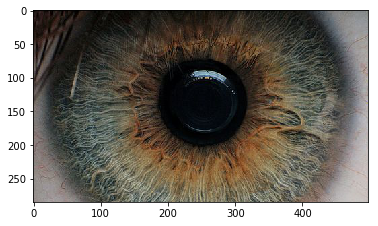

In [16]:
new_image = (pixel_processor.convolution(Filters.identity()))
imshow(new_image)
print(f'Origin shape {pixel_processor.img.shape} --> New shape {new_image.shape}')

Applying filter [ 0 -1  0 -1  5 -1  0 -1  0]
Origin shape (287, 500, 3) --> New shape (285, 498, 3)


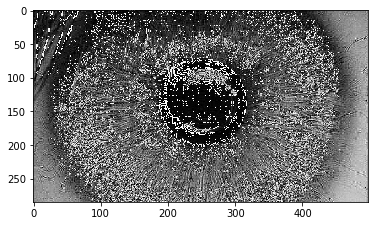

In [49]:
new_image = (pixel_processor.convolution(Filters.sharpen(), True))
imshow(new_image)
print(f'Origin shape {pixel_processor.img.shape} --> New shape {new_image.shape}')

# 2. Morphological Image Processing

In [7]:
# Wrappers
def return_uint8(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.uint8)
    return func_wrapper

def return_float32(func):
    def func_wrapper(*args):
        output = func(*args)
        return output.astype(np.float32)
    return func_wrapper

def normalize(func):
    def func_wrapper(*args):
        output = func(*args)
        output[output < 0] = 0
        output[output > 255] = 255
        return output
    return func_wrapper

In [8]:
@return_uint8
def get_brightness(img, brightness):
    brightened = np.apply_along_axis(lambda pixel,brightness: [min(max(c+brightness,0),255) for c in pixel], -1, img, brightness)
    return brightened

def get_negate(img):
    return 1-img
#     return np.apply_along_axis(lambda pixel: [1 if c == 254 else 0 for c in pixel], -1, img).astype(np.float32)

@return_uint8
def get_grey_image(img):
    return np.apply_along_axis(_pixel2gray, -1, img)

def get_global_thresholding_simple(img, threshold):
    # http://www.cse.iitd.ernet.in/~pkalra/col783/Thresholding.pdf
    img = get_grey_image(img)
    return np.apply_along_axis(_threshold, -1, img, threshold)

@return_uint8
@normalize
def get_contrast(img, contrast: float):
    # http://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/
    F = (259 * (contrast + 255)) / (255 * (259 - contrast))
    return np.apply_along_axis(contrast_pixel, -1, img, F)

@return_float32
def get_dilatation(img, dimension):
    out = np.ndarray(img.shape, dtype=np.uint8)
    for (i, j, c), v in tqdm(np.ndenumerate(img)):
        neighbours = img[i:i+dimension,j:j+dimension]
        out[i,j] = img[i,j]
        for (row, column, color), _ in np.ndenumerate(neighbours):
            if neighbours[row, column, 0] == 1.:
                out[i,j] = [1.,1.,1.]
    return out

@return_float32
def get_erosion(img, dimension):
    out = np.ndarray(img.shape, dtype=np.uint8)
    for (i, j, c), v in tqdm(np.ndenumerate(img)):
        neighbours = img[i:i+dimension,j:j+dimension]
        out[i,j] = img[i,j]
        for (row, column, color), _ in np.ndenumerate(neighbours):
            if neighbours[row, column, 0] == 0.:
                out[i,j] = [0.,0.,0.]
    return out

@return_float32
def get_masked_image(img, mask):
    out = np.ones(img.shape, dtype=np.float32)
    mask = mask.astype(bool)
    out[~mask] = ~img[~mask]
    return out

def get_opening(img, dimension):
    out = get_erosion(img, dimension)
    out = get_dilatation(out, dimension)
    return out

def get_closing(img, dimension):
    out = get_dilatation(img, dimension)
    out = get_erosion(out, dimension)
    return out

def _pixel2gray(pixel):
    grey = int(sum(pixel) // 3)  # Average of 3 colors
    return [grey] * len(pixel)


def _threshold(pixel, threshold):
    return [1. if color > threshold else 0. for color in pixel]

def contrast_pixel(pixel, factor):
    return [factor * (color - 128) + 128 for color in pixel]


# Iris segmentation

## Pupil extraction

In [9]:
iris_segmentation = img.copy()

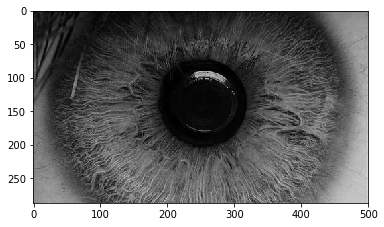

In [10]:
grey = get_grey_image(iris_segmentation)
imshow(grey)

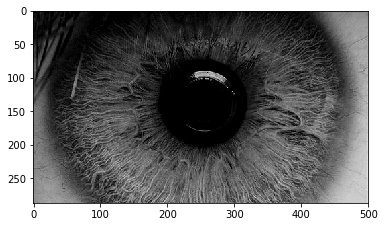

In [11]:
contrasted = get_contrast(grey, 15)
imshow(contrasted)

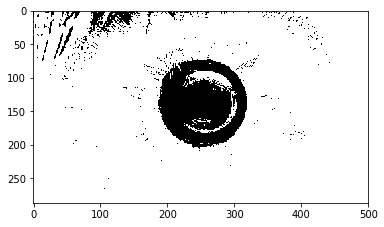

In [23]:
iris_mask = get_global_thresholding_simple(contrasted, 1)
imshow(iris_mask)

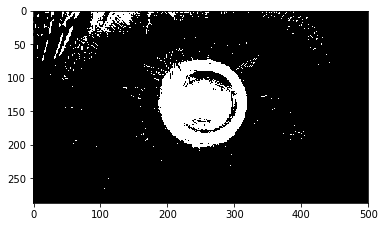

In [24]:
iris_mask = 1-iris_mask
imshow(iris_mask)

430500it [00:09, 43675.27it/s]


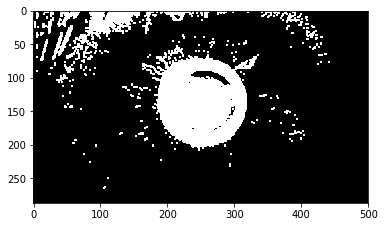

In [25]:
iris_mask = get_dilatation(iris_mask, 3)
imshow(iris_mask)

430500it [00:57, 7446.79it/s]


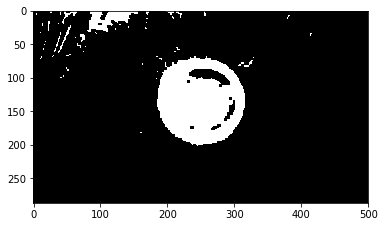

In [26]:
iris_mask = get_erosion(iris_mask, 4)
imshow(iris_mask)

430500it [00:59, 7267.66it/s] 
430500it [00:39, 10896.19it/s]


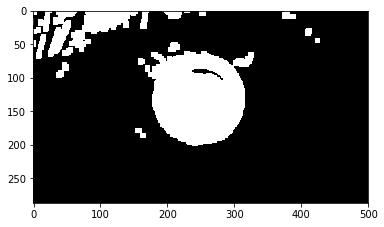

In [27]:
dilation_times = 2
for i in range(5,5-dilation_times,-1):
    iris_mask = get_dilatation(iris_mask, i)
imshow(iris_mask)

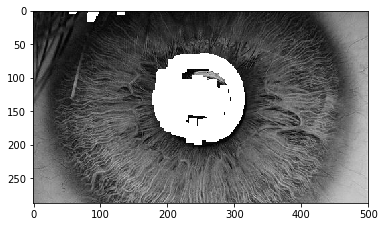

In [213]:
masked_pupil = get_masked_image(grey, iris_mask)
imshow(masked_pupil.astype

## Sclera Extraction

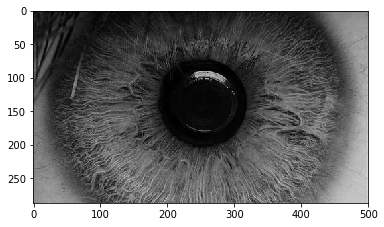

In [160]:
grey = get_grey_image(iris_segmentation)
imshow(grey)

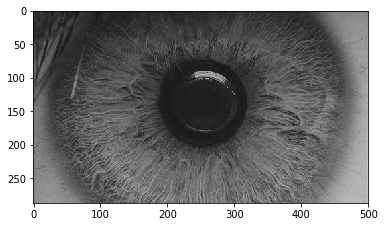

In [154]:
contrasted = get_contrast(grey, -30)
imshow(contrasted)

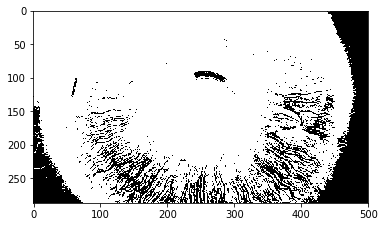

In [155]:
sclera_mask1 = get_global_thresholding_simple(1-contrasted, 140)
imshow(sclera_mask1)

430500it [00:08, 48164.77it/s]
430500it [00:41, 10443.42it/s]
430500it [01:53, 3793.64it/s]


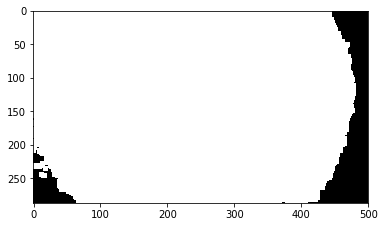

In [200]:
sizes = [2,3,5]
sclera_mask2 = sclera_mask1.copy()
for i in range(len(sizes)):
    sclera_mask2 = get_dilatation(sclera_mask2, sizes[i])
imshow(sclera_mask2)

In [226]:
# inverse
sclera_mask2 = 1-sclera_mask2

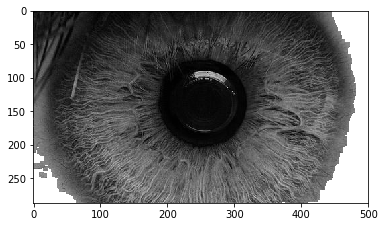

In [227]:
masked_sclera = get_masked_image(grey, sclera_mask2)
imshow(masked_sclera)

In [224]:
sclera_mask2[286][:2]

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)

## Together

In [231]:
def merge_masks(mask1, mask2):
    out = np.zeros(mask1.shape)
    out[(mask1 == 1)|(mask2 == 1)] = 1
    return out

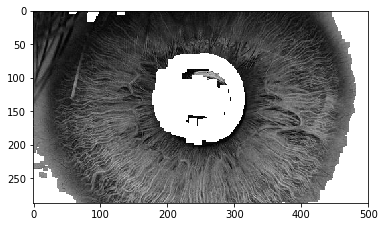

In [232]:
mask_together = merge_masks(iris_mask, sclera_mask2)
together = get_masked_image(grey, mask_together)
imshow(together)

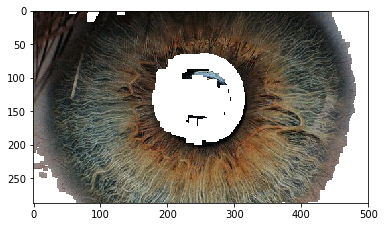

In [233]:
mask_together = merge_masks(iris_mask, sclera_mask2)
together = get_masked_image(img, mask_together)
imshow(together)